In [41]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt

import pandas as pd
import numpy as np
from pygents.plot import plot_dict


In [2]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "./data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

In [3]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


## Explore performance of "our out of the box" model with dataset 1 (original binary)

In [16]:
df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)l", value = np.nan)
df1


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


In [42]:
from pygents.aigents_api import TextMetrics
#from pygents.util import vector_proximity


def language_metrics(lang,metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = './data/dict/' + lang + '/' + m + '.txt'
    return metrics


distortion_labels = ['positive','negative','rude',
'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning','fortune-telling',
'labeling','magnification','mental-filtering','mindreading','overgeneralizing','personalizing','should-statement']
tm = TextMetrics(language_metrics('en',distortion_labels),debug=False)

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df(df,evaluator,threshold,debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return f1_from_counts(true_positive, true_negative, false_positive, false_negative) 


def our_evaluator_any(text,threshold):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False
  

In [18]:
print('Any distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df1,our_evaluator_any,threshold)
    print(threshold, f1)
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df1,our_evaluator_avg,threshold)
    print(threshold, f1)

Any distortion:
0.0 0.8443643512450851
0.01 0.8443643512450851
0.05 0.8443643512450851
0.1 0.8443643512450851
0.2 0.8445027035883992
0.4 0.8444669365721997
0.6 0.5569898379566054
0.8 0.013021830716200687
Average distortion:
0.0 0.8443643512450851
0.01 0.8443643512450851
0.05 0.8443643512450851
0.1 0.8443643512450851
0.2 0.8447795443369939
0.4 0.886836935166994
0.6 0.18404478656403078
0.8 0.007680491551459293


## Explore performance of "our out of the box" model with dataset 2 (original multi-class)

In [19]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [20]:
print('Any distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df2,our_evaluator_any,threshold)
    print(threshold, f1)
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df2,our_evaluator_avg,threshold)
    print(threshold, f1)

Any distortion:
0.0 0.7688564476885645
0.01 0.7688564476885645
0.05 0.7688564476885645
0.1 0.7688564476885645
0.2 0.7692307692307692
0.4 0.7668822768434671
0.6 0.34928716904276985
0.8 0.007485963817841547
Average distortion:
0.0 0.7688564476885645
0.01 0.7688564476885645
0.05 0.7688564476885645
0.1 0.7688564476885645
0.2 0.7701681696319767
0.4 0.7886843899113838
0.6 0.11667648791985859
0.8 0.004996876951905059


## Explore performance of "our out of the box" model with dataset 3 (joint 1 + 2)

In [21]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


In [43]:
print('Any distortion:')
any_res = {}
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df3,our_evaluator_any,threshold)
    any_res[threshold] = f1
    print(threshold, f1)
avg_res = {}
print('Average distortion:')
for threshold in [0.0,0.01,0.05,0.1,0.2,0.4,0.6,0.8]:
    f1 = evaluate_df(df3,our_evaluator_avg,threshold)
    avg_res[threshold] = f1
    print(threshold, f1)
    

Any distortion:
0.0 0.8139808106520462
0.01 0.8139808106520462
0.05 0.8139808106520462
0.1 0.8139808106520462
0.2 0.8142199588678876
0.4 0.8138466251404064
0.6 0.4842105263157895
0.8 0.010915994304698622
Average distortion:
0.0 0.8139808106520462
0.01 0.8139808106520462
0.05 0.8139808106520462
0.1 0.8139808106520462
0.2 0.814778518228146
0.4 0.8509471585244267
0.6 0.15894621295279912
0.8 0.006658739595719382


In [67]:
import random
def our_evaluator_true(text,threshold):
    return False
def our_evaluator_false(text,threshold):
    return False
def our_evaluator_random(text,threshold):
    return random.choice([True, False])
f1_t = evaluate_df(df3,our_evaluator_true,0)
f1_f = evaluate_df(df3,our_evaluator_false,0)
f1_r1 = evaluate_df(df3,our_evaluator_random,0)
f1_r2 = evaluate_df(df3,our_evaluator_random,0)
f1_r3 = evaluate_df(df3,our_evaluator_random,0)
print(f1_t,f1_f,f1_r1,f1_r2,f1_r3)

0 0 0.5772425249169436 0.5893599334995845 0.5849628201597356


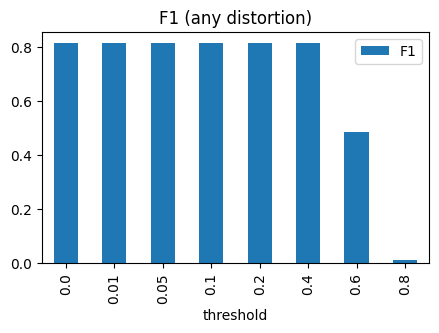

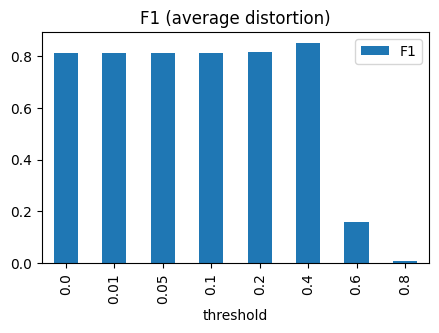

In [55]:
import matplotlib.pyplot as plt

def plot_dict_bars(dic,labels,values,title=None,head=None,dim=(5,3)):
    df = pd.DataFrame([(key, dic[key]) for key in dic],columns=[labels,values])
    #df.sort_values(values,ascending=False,inplace=True)
    if head is not None:
        df = df[:head]
    if not dim is None:
        plt.rcParams["figure.figsize"] = dim
    p = df[[labels,values]].plot.bar(x=labels); #p.invert_yaxis();
    if title is not None:
        plt.title(title)

plot_dict_bars(any_res, labels="threshold", values="F1", title=f"F1 (any distortion)")
plot_dict_bars(avg_res, labels="threshold", values="F1", title=f"F1 (average distortion)")


## Explore runtime performance of "our out of the box" model with dataset 3 (joint 1 + 2)

See ./notebooks/nlp/distortions/distortions_llm.ipynb

- binary classification F1 = 0.85 (average distortion metric with sensitivity threshold 0.4)
- LLM llama3.2 runtime performance ~1 sec / text (103 min / dataset 3, with GPU use)
- LLM qwen2 runtime performance ~1.9 sec / text (193 min / dataset 3, with GPU use)
- OUR runtime performance ~0.7 msec / text (4 sec / dataset 3, ~1500 times faster, F1 2% ahead both LLM-s with F1=0.83/0.81)


In [32]:
t0 = dt.datetime.now()

f1 = evaluate_df(df3,our_evaluator_avg,0.4,debug=False)

t1 = dt.datetime.now()
delta = t1 - t0
print(f1,delta.total_seconds(),delta.total_seconds()/len(df3))


0.8509471585244267 4.095428 0.0006761479280171703


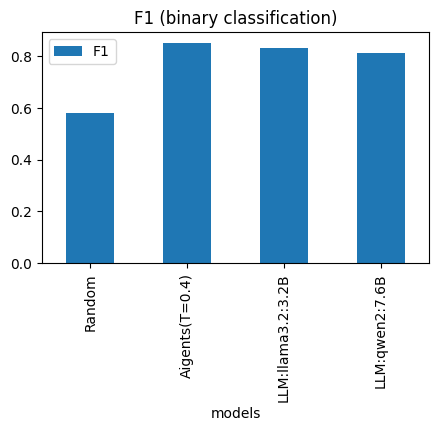

In [71]:
plot_dict_bars({"Random":0.58,"Aigents(T=0.4)":0.85,"LLM:llama3.2:3.2B":0.83,"LLM:qwen2:7.6B":0.81}, labels="models", values="F1", title=f"F1 (binary classification)")

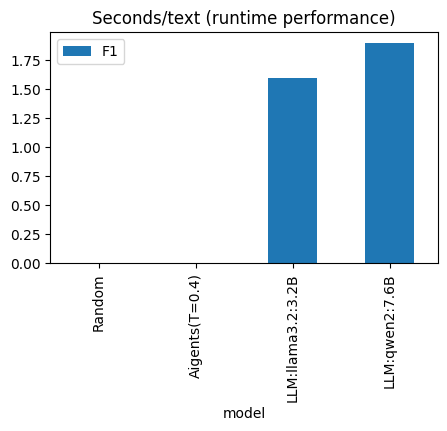

In [72]:
plot_dict_bars({"Random":0,"Aigents(T=0.4)":0.0007,"LLM:llama3.2:3.2B":1.6,"LLM:qwen2:7.6B":1.9}, labels="model", values="F1", title=f"Seconds/text (runtime performance)")